In [1]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the paths
zip_file_path = '/content/drive/My Drive/archive (6).zip'  # Adjust the path to your file location
destination_folder = '/content/flower_dataset'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

print(f"Extracted files to: {destination_folder}")


Mounted at /content/drive
Extracted files to: /content/flower_dataset


In [2]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms,datasets
from torch.utils.data import DataLoader

In [3]:
train_transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
test_transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
valid_transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [4]:
data_dir='/content/flower_dataset'
import os
train_dir=os.path.join(data_dir,'train')
test_dir=os.path.join(data_dir,'test')
valid_dir=os.path.join(data_dir,'valid')

In [5]:
train_dataset=datasets.ImageFolder(root=train_dir,transform=train_transform)
test_dataset=datasets.ImageFolder(root=test_dir,transform=test_transform)
valid_dataset=datasets.ImageFolder(root=valid_dir,transform=valid_transform)

In [6]:
train_loader=DataLoader(dataset=train_dataset,batch_size=32,shuffle=True)
test_loader=DataLoader(dataset=test_dataset,batch_size=32,shuffle=True)
valid_loader=DataLoader(dataset=valid_dataset,shuffle=True,batch_size=32)

In [7]:
class_names=train_dataset.classes
print(class_names)

['daisy', 'dandelion']


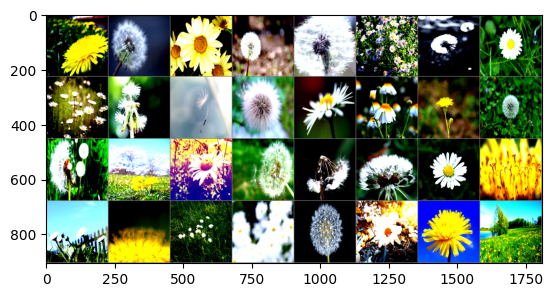

dandelion dandelion daisy dandelion dandelion daisy dandelion daisy daisy dandelion dandelion dandelion daisy daisy dandelion dandelion dandelion dandelion daisy dandelion dandelion dandelion daisy dandelion daisy dandelion daisy daisy dandelion daisy dandelion dandelion


In [9]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img=img/2+0.5
  npimg=img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()

dataiter=iter(train_loader)
images,labels=next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{class_names[labels[j]]:5}' for j in range(32)))

In [10]:
from torchvision import models
model=models.resnet18(pretrained=True)
num_ftrs=model.fc.in_features
model.fc=nn.Linear(num_ftrs,2)

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 102MB/s] 


In [11]:
import torch.optim as optim
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001)

In [13]:
num_epochs=10
for epoch in range(num_epochs):
  total=0
  correct=0
  running_loss=0.0
  model.train()
  train_dataset_size=len(train_dataset)
  for images,labels in train_loader:
    images=images.to(device)
    labels=labels.to(device)
    optimizer.zero_grad()
    outputs=model(images)
    loss=criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    _,predicted=torch.max(outputs,1)
    total+=labels.size(0)
    correct+=(predicted==labels).sum().item()
    running_loss+=loss.item()
  epoch_loss=running_loss/len(train_loader)
  epoch_acc=correct/total
  print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

model.eval()
valid_loss=0.0
valid_correct=0
valid_total=0
with torch.no_grad():
  for images,labels in valid_loader:
    images=images.to(device)
    labels=labels.to(device)
    outputs=model(images)
    _,preds=torch.max(outputs,1)
    loss=criterion(outputs,labels)
    valid_loss+=loss.item()
    valid_total+=labels.size(0)
    valid_correct+=(preds==labels).sum().item()
valid_loss=valid_loss/len(valid_loader)
valid_acc=valid_correct/valid_total
print(f'Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.4f}')

Epoch 1/10, Loss: 0.1558, Accuracy: 0.9561
Epoch 2/10, Loss: 0.1335, Accuracy: 0.9663
Epoch 3/10, Loss: 0.1358, Accuracy: 0.9616
Epoch 4/10, Loss: 0.1323, Accuracy: 0.9616
Epoch 5/10, Loss: 0.1295, Accuracy: 0.9576
Epoch 6/10, Loss: 0.1262, Accuracy: 0.9639
Epoch 7/10, Loss: 0.1115, Accuracy: 0.9694
Epoch 8/10, Loss: 0.1178, Accuracy: 0.9647
Epoch 9/10, Loss: 0.1043, Accuracy: 0.9710
Epoch 10/10, Loss: 0.1015, Accuracy: 0.9733
Validation Loss: 0.1170, Validation Accuracy: 0.9505


In [15]:
model.eval()
test_loss=0.0
test_correct=0
test_total=0
with torch.no_grad():
  for images,labels in test_loader:
    images=images.to(device)
    labels=labels.to(device)
    outputs=model(images)
    _,preds=torch.max(outputs,1)
    loss=criterion(outputs,labels)
    test_loss+=loss.item()
    test_total+=labels.size(0)
    test_correct+=(preds==labels).sum().item()
test_loss=test_loss/len(test_loader)
test_acc=test_correct/test_total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

Test Loss: 0.1374, Test Accuracy: 0.9396
